In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "drive/My Drive/farha/train.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
import shutil, os, glob
 
def moveAllFilesinDir(srcDir, dstDir):
    # Check if both the are directories
    if os.path.isdir(srcDir) and os.path.isdir(dstDir) :
        # Iterate over all the files in source directory
        for filePath in glob.glob(srcDir + '/*'):
            # Move each file to destination Directory
            shutil.move(filePath, dstDir);
    else:
        print("srcDir & dstDir should be Directories")

!mkdir tmp
!mkdir tmp/train
!mkdir tmp/train/0
!mkdir tmp/train/1
!mkdir tmp/train/2
!mkdir tmp/train/3
!mkdir tmp/train/4

moveAllFilesinDir('train/0', 'tmp/train/0')
moveAllFilesinDir('train/1', 'tmp/train/1')
moveAllFilesinDir('train/2', 'tmp/train/2')
moveAllFilesinDir('train/3', 'tmp/train/3')
moveAllFilesinDir('train/4', 'tmp/train/4')

!mkdir tmp/test
!mkdir tmp/test/0
!mkdir tmp/test/1
!mkdir tmp/test/2
!mkdir tmp/test/3
!mkdir tmp/test/4

BASE_DIR = "tmp/train/"
NEW_DIR= "tmp/test/"

list_dir =  os.listdir(BASE_DIR)

for tdir in list_dir:
    list_images = os.listdir(BASE_DIR+tdir)
    to_val = random.sample(list_images, len(list_images)//5)
    for images in to_val:
        os.rename(BASE_DIR + str(tdir) + "/"+ images, NEW_DIR + str(tdir) + "/" + images )

print('Train Images')
!ls tmp/train/0 | wc -l
!ls tmp/train/1 | wc -l
!ls tmp/train/2 | wc -l
!ls tmp/train/3 | wc -l
!ls tmp/train/4 | wc -l

print('Test Images')
!ls tmp/test/0 | wc -l
!ls tmp/test/1 | wc -l
!ls tmp/test/2 | wc -l
!ls tmp/test/3 | wc -l
!ls tmp/test/4 | wc -l

Train Images
7032
3731
4027
2652
2169
Test Images
1758
932
1006
662
542


In [13]:
from fastai import *
from fastai.vision import *
from torchvision.models import *     # import *=all the models from torchvision  

arch = squeezenet1_0                    # specify model architecture, densenet169 seems to perform well for this data but you could experiment
bs = 16                              # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = 256                             # input size is the crop size
#MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [14]:
PATH ='tmp/'
tfms = get_transforms(do_flip=True,max_zoom=1.3, max_rotate=0, max_warp=0, p_affine=0, p_lighting=0)

data = ImageDataBunch.from_folder('tmp',ds_tfms = tfms, valid_pct=0.05, test='test', size=sz, bs=bs)

In [15]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (18631 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
4,4,4,4,4
Path: tmp;

Valid: LabelList (980 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,3,3,3,1
Path: tmp;

Test: LabelList (4900 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: tmp

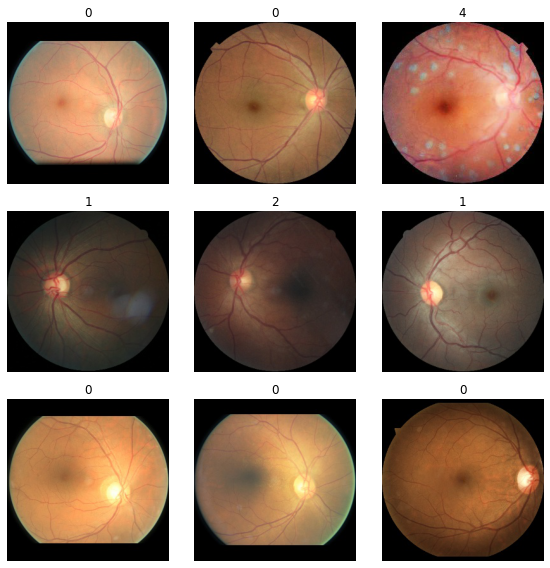

In [16]:
data.show_batch(rows=3, figsize=(8,8));

In [29]:
learner = cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

In [18]:
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4') 

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


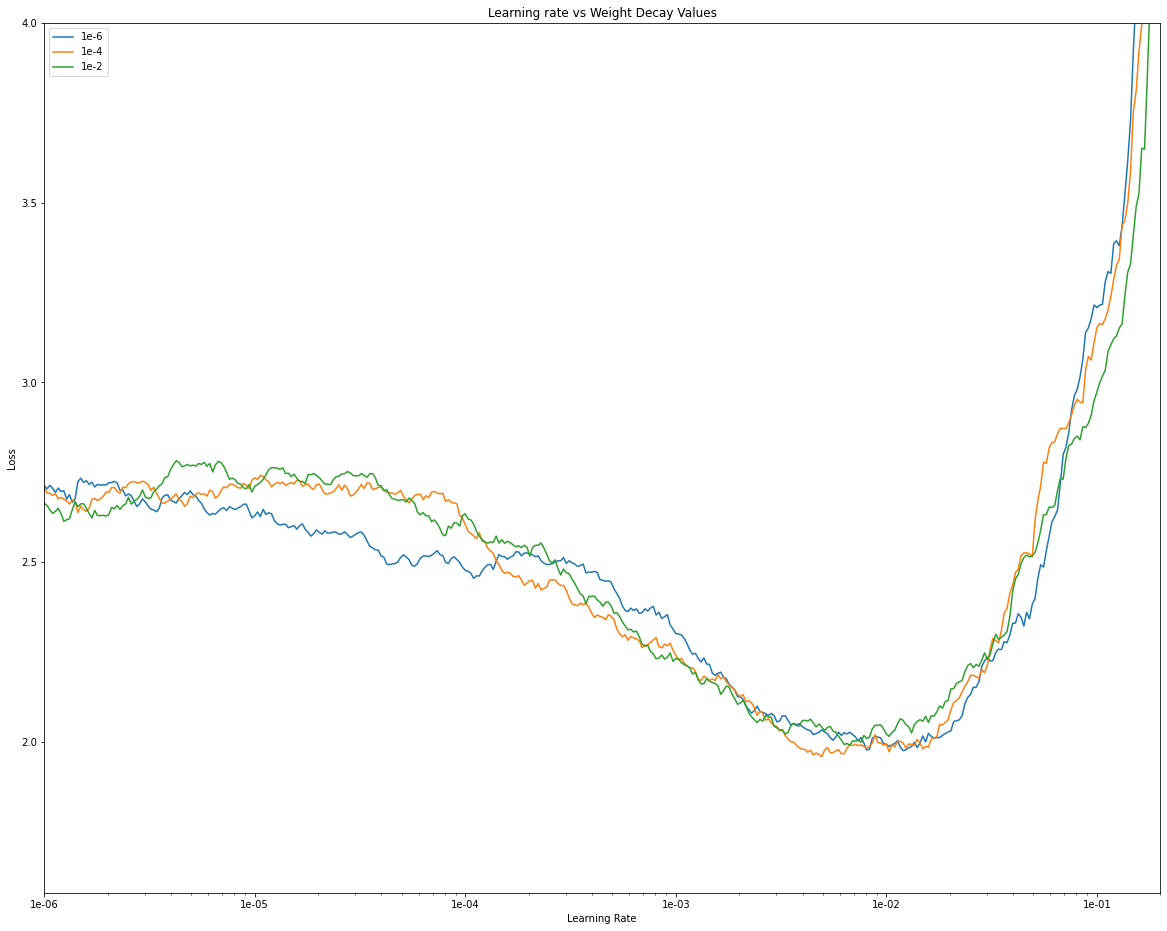

In [19]:
_, ax = plt.subplots(1,1, figsize=(20, 16))
plt.title('Learning rate vs Weight Decay Values')
min_y = 1.6
max_y = 4
for i in range(len(losses)):
    ax.plot(np.array(lrs[i]), np.array(losses[i]))
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate") 
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-6,2e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [20]:
from torchsummary import summary
summary(learner.model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 253, 253]          14,208
              ReLU-2         [-1, 96, 253, 253]               0
         MaxPool2d-3         [-1, 96, 126, 126]               0
            Conv2d-4         [-1, 16, 126, 126]           1,552
              ReLU-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 64, 126, 126]           1,088
              ReLU-7         [-1, 64, 126, 126]               0
            Conv2d-8         [-1, 64, 126, 126]           9,280
              ReLU-9         [-1, 64, 126, 126]               0
             Fire-10        [-1, 128, 126, 126]               0
           Conv2d-11         [-1, 16, 126, 126]           2,064
             ReLU-12         [-1, 16, 126, 126]               0
           Conv2d-13         [-1, 64, 126, 126]           1,088
             ReLU-14         [-1, 64, 1

epoch,train_loss,valid_loss,accuracy,time
0,1.247347,1.120594,0.513265,01:15
1,1.165370,1.002367,0.590816,01:15
2,1.084919,0.975968,0.592857,01:14
3,1.099310,0.988474,0.603061,01:15
4,1.064724,0.929942,0.637755,01:15
5,1.030048,0.905965,0.653061,01:15
6,1.029472,1.326560,0.645918,01:15
7,0.990208,1.207911,0.666327,01:15
8,0.990077,0.950649,0.639796,01:15
9,0.962118,0.980969,0.664286,01:15


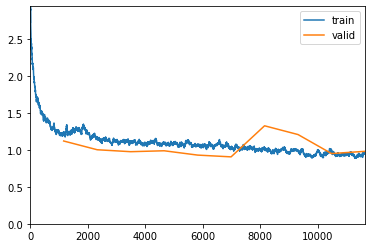

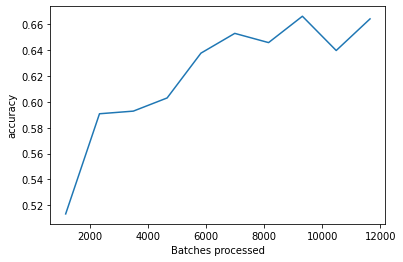

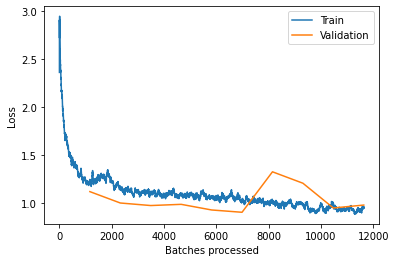

In [22]:
wd = 1e-6
min_sl = 1e-4
max_sl = 1e-2

learner.fit_one_cycle(10, max_lr=slice(min_sl,max_sl))

learner.recorder.plot_metrics()

learner.recorder.plot_losses()

In [23]:
learner.save('squeezenet_freezed_10cy')

In [24]:
learner.unfreeze()
learner.lr_find(wd=1e-6, num_it=iter_count)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


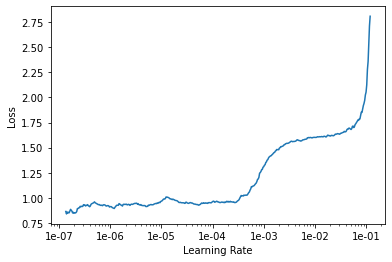

In [25]:
learner.recorder.plot()

In [30]:
learner = cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time
0,1.226307,0.984305,0.606122,01:15
1,1.149044,1.019814,0.618367,01:15
2,1.156129,0.982668,0.569388,01:15
3,1.140605,0.915103,0.643878,01:15
4,1.115823,0.996300,0.544898,01:15
5,1.098058,1.077809,0.584694,01:15
6,1.095845,1.018080,0.581633,01:15
7,1.084849,0.896812,0.625510,01:15
8,1.056842,0.933940,0.631633,01:15
9,1.083478,0.963830,0.620408,01:15


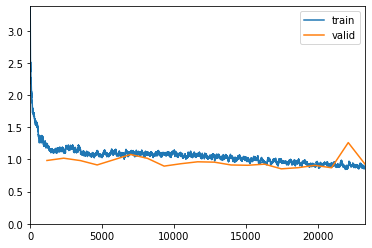

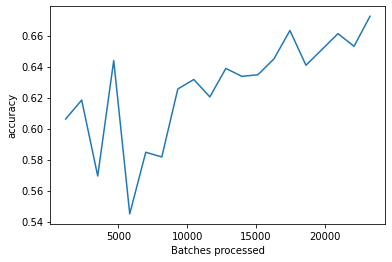

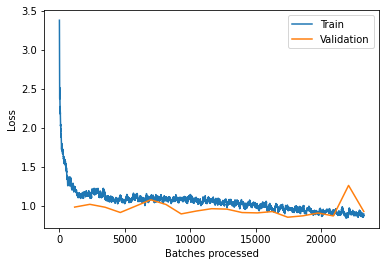

In [31]:
wd = 1e-6
min_sl = 1e-4
max_sl = 1e-2

learner.fit_one_cycle(20, max_lr=slice(min_sl,max_sl))

learner.recorder.plot_metrics()

learner.recorder.plot_losses()

In [ ]:

learner.recorder.plot_metrics()

learner.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,1.236110,0.922116,0.624490,01:16
1,1.074929,0.923098,0.631633,01:15
2,1.080502,0.922684,0.631633,01:15
3,1.111581,0.923077,0.625510,01:15
4,1.046989,0.971097,0.592857,01:15
5,1.041875,0.892941,0.648980,01:14
6,1.011261,0.893194,0.638776,01:15
7,0.999346,0.894706,0.632653,01:15
8,1.055226,0.908902,0.624490,01:15
9,1.059920,0.889403,0.654082,01:15


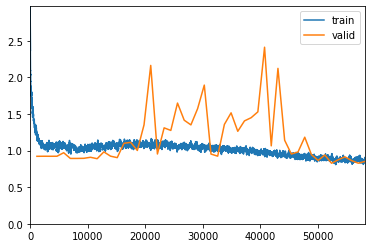

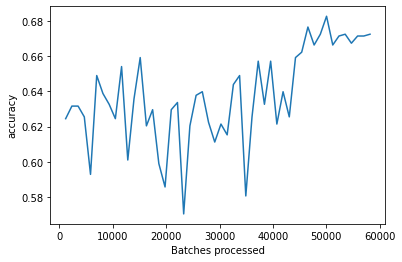

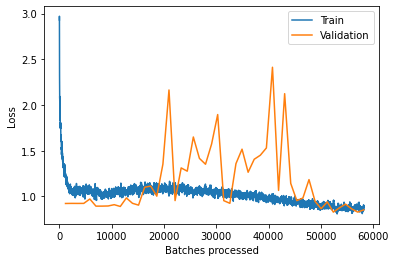

In [33]:
learner = cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

wd = 1e-6
min_sl = 1e-4
max_sl = 1e-2

learner.fit_one_cycle(50, max_lr=slice(min_sl,max_sl))

learner.recorder.plot_metrics()

learner.recorder.plot_losses()

In [34]:
learner.save('squeezenet_freezed_30cy')

In [35]:
learner.export('squeezenet_freezed_30cy_pred.pkl')

In [37]:
!cp -r /content/models /content/drive/'My Drive'/farha/models

In [40]:
!cp /content/squeezenet_freezed_30cy_pred.pkl /content/drive/'My Drive'/farha/models